# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
! ls ../../data/Term2/capstone/arvato_data/

Udacity_AZDIAS_052018.csv     Udacity_MAILOUT_052018_TEST.csv
Udacity_CUSTOMERS_052018.csv  Udacity_MAILOUT_052018_TRAIN.csv


In [4]:
! cp ../../data/Term2/capstone/arvato_data/* . -fv

'../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv' -> './Udacity_AZDIAS_052018.csv'
'../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv' -> './Udacity_CUSTOMERS_052018.csv'
'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv' -> './Udacity_MAILOUT_052018_TEST.csv'
'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv' -> './Udacity_MAILOUT_052018_TRAIN.csv'


In [5]:
! zip all.zip * .csv

	zip warning: name not matched: .csv
updating: Arvato Project Workbook.ipynb (deflated 65%)
updating: Arvato-Project-Workbook-zh.ipynb (deflated 58%)
updating: Arvato_Project_Workbook (3).ipynb (deflated 71%)
updating: DIAS Attributes - Values 2017.xlsx (deflated 10%)
updating: DIAS Information Levels - Attributes 2017.xlsx (deflated 15%)
updating: Udacity_AZDIAS_052018.csv (deflated 78%)
updating: Udacity_CUSTOMERS_052018.csv (deflated 81%)
updating: Udacity_MAILOUT_052018_TEST.csv (deflated 79%)
updating: Udacity_MAILOUT_052018_TRAIN.csv (deflated 79%)
updating: terms_and_conditions/ (stored 0%)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
%%capture
!aws s3 cp Zipall s3://capstoneproject/ --recursive

In [7]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
print('Data Loaded Successfully.......!')

Data Loaded Successfully.......!


### Checking out the General populations' data (Azdias)

In [8]:
#there is a lot of missing vlaues
azdias.head

<bound method NDFrame.head of            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       910215        -1         NaN       NaN          NaN          NaN   
1       910220        -1         9.0       0.0          NaN          NaN   
2       910225        -1         9.0      17.0          NaN          NaN   
3       910226         2         1.0      13.0          NaN          NaN   
4       910241        -1         1.0      20.0          NaN          NaN   
5       910244         3         1.0      10.0          NaN          NaN   
6       910248        -1         9.0       0.0          NaN          NaN   
7       910261        -1         1.0      14.0          NaN          NaN   
8       645145        -1         9.0      16.0          NaN          NaN   
9       645153        -1         5.0      17.0          NaN          NaN   
10      645165         0         1.0      10.0          NaN          NaN   
11      645169        -1         NaN       NaN          Na

In [9]:
#there is 6 catecories
azdias.select_dtypes(include='object').nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

In [10]:
#we need to preprocess the data
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [11]:
#number of unknown values in general
unknowns=azdias.isnull().sum().sum()
print(unknowns)

33492923


### Attributes data/information

In [12]:
attributes.head

<bound method NDFrame.head of       Unnamed: 0             Attribute  \
0            NaN              AGER_TYP   
1            NaN                   NaN   
2            NaN                   NaN   
3            NaN                   NaN   
4            NaN                   NaN   
5            NaN  ALTERSKATEGORIE_GROB   
6            NaN                   NaN   
7            NaN                   NaN   
8            NaN                   NaN   
9            NaN                   NaN   
10           NaN                   NaN   
11           NaN              ALTER_HH   
12           NaN                   NaN   
13           NaN                   NaN   
14           NaN                   NaN   
15           NaN                   NaN   
16           NaN                   NaN   
17           NaN                   NaN   
18           NaN                   NaN   
19           NaN                   NaN   
20           NaN                   NaN   
21           NaN                   NaN   
22  

missing values inform of (-1,0,9 and even 10)

In [13]:
attributes[attributes.Meaning.str.contains('know',na=False)]

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown
48,NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,NaN,CJT_GESAMTTYP,customer journey typology,0,unknown
138,NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known


WE NEED TO CONVERT THEM TO NAN

###  customers data characteristics

In [14]:
customers.head

<bound method NDFrame.head of            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0         9626         2         1.0      10.0          NaN          NaN   
1         9628        -1         9.0      11.0          NaN          NaN   
2       143872        -1         1.0       6.0          NaN          NaN   
3       143873         1         1.0       8.0          NaN          NaN   
4       143874        -1         1.0      20.0          NaN          NaN   
5       143888         1         1.0      11.0          NaN          NaN   
6       143904         2         1.0      10.0          NaN          NaN   
7       143910         1         1.0      10.0          NaN          NaN   
8       102160         2         3.0       5.0          NaN          NaN   
9       102173         1         1.0      20.0          NaN          NaN   
10      102184        -1         7.0      14.0          NaN          NaN   
11      102185         1         1.0      10.0          Na

In [15]:
#there is 6 features that are categoricals
customers.select_dtypes(include='object').nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               3034
OST_WEST_KZ                    2
PRODUCT_GROUP                  3
CUSTOMER_GROUP                 2
dtype: int64

In [16]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [17]:
#no of nuknow
unknowns2=customers.isnull().sum().sum()
print(unknowns2)

13864522


In [18]:
customers.CUSTOMER_GROUP.value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

### Cleaning the Datasets

we will drop all col with 30%+ and fill numerical with median and categorical with most common

In [19]:
#the data is so big so will use a small amount
population = azdias.sample(n=2000)
customers= customers.sample(n=2000)
print(population.shape,customers.shape)

(2000, 366) (2000, 369)


In [20]:
#simple encoding
customers.replace({'PRODUCT_GROUP':{'COSMETIC':0,'FOOD':1,'COSMETIC_AND_FOOD':2},
                   'CUSTOMER_GROUP':{'MULTI_BUYER':0,'SINGLE_BUYER':1}
                   },inplace=True)

In [29]:
def identify(attributes):

    #founding the unuknow
    df=attributes.copy()
    df = df[df.Meaning.str.contains('know',na=False)].reset_index(drop=True)
    
    s = df['Value'].str.split(',').apply(pd.Series, 1).stack() 
    s.index = s.index.droplevel(1)
    s.name='New_value'
    df = df.join(s)  
    #joins with the new value
    df.loc[df.New_value.isna(),'New_value']=df[~df.Value.str.contains(',',na=False)].Value 
    df.reset_index(drop=True,inplace=True)
    df['New_value']=df['New_value'].astype(float)
    
    return df

def unknown(df,new_attributes):

#replacing with nan
  df_1 = df.copy()
  cols = df_1.columns.intersection(new_attributes.columns)
  for i in range(len(new_attributes[cols])):
    value = new_attributes.loc[i,'New_value']
    col = new_attributes.loc[0,'Attribute']
    mask = df_1[col] == value
    df_1[mask]= np.nan
        
    return df_1

In [30]:
def drop(df):
    #droping col with 30%+ missing
    
    df_1 = (df.isnull().sum()/df.shape[0])>0.3
    df_2 = df[df.columns[~df_1]]
    
    return df_2

In [31]:
#imputing numerical with Median and mode for categorical
def impute(df,new_attributes):
    
    dt=new_attributes.copy()
    data=df.copy()
    
    dt=dt[dt.Meaning.str.contains('numeric',na=False)]

    mask = dt.Attribute.values
    data[mask]= data[mask].fillna(data.median())
    
    mask = data.columns.difference(mask)
    data[mask]= data[mask].fillna(data.mode().iloc[0])
    
    print("after filling".format(data.isnull().sum().sum()))
    
    return data

In [32]:
#scaling and droping col
def encode_data(df,new_attributes):

    # encoding
    
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].astype(str).replace({"X": np.nan, "XX": np.nan}).astype(float)
    df.fillna(0,inplace=True)


    # droping
    
    cols= ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ']
    df=df.drop(columns=cols,axis=1)

    # Scaleing
    
    scaler = StandardScaler()
    scaled_arr = scaler.fit_transform(df)
    data_scaled = pd.DataFrame(scaled_arr, columns = df.columns)
    df =data_scaled

    return df

In [33]:
#all in one function
def clean_data(data,attributes):
    
    new_attributes = identify(attributes)
    data = drop(data)
    data = unknown(data,new_attributes)
    data = impute(data,new_attributes)
    data = encode_data(data,new_attributes)
    
    data.fillna(method='ffill',inplace=True)
    
    return data

In [34]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 228465 to 443852
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 5.6+ MB


In [35]:
encode_data(population,attributes)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.493582,-0.547081,1.305335,-1.272903,-0.279415,-0.172248,-0.070172,-0.022366,1.346898,-0.402418,...,-0.046655,0.424692,0.797140,0.472270,-0.214819,-0.110267,-0.309455,-1.725427,-1.030464,0.212019
1,0.603990,1.924669,-0.838072,-0.131002,-0.279415,-0.172248,-0.070172,-0.022366,-0.102442,-0.193007,...,1.422794,0.424692,0.532442,0.154671,1.115331,0.597705,-0.309455,-0.265366,-1.030464,0.212019
2,1.222682,-0.547081,-0.838072,-1.272903,-0.279415,-0.172248,-0.070172,-0.022366,1.083381,-0.402418,...,1.422794,-0.495551,0.003044,-0.162928,0.228564,0.597705,0.585570,-0.265366,0.970437,0.212019
3,1.074903,1.924669,-0.838072,-0.004124,-0.279415,-0.172248,-0.070172,-0.022366,0.029316,-0.193007,...,1.422794,0.424692,0.267743,-0.162928,1.115331,-0.818238,-0.309455,1.924725,-1.030464,0.212019
4,1.180276,-0.547081,1.305335,0.630266,-0.279415,-0.172248,-0.070172,-0.022366,0.819865,-0.262810,...,-0.046655,0.424692,0.797140,1.425067,-0.214819,0.597705,-0.309455,0.464664,0.970437,0.212019
5,-1.447642,-0.547081,1.305335,1.010900,-0.279415,-0.172248,-0.070172,-0.022366,1.083381,0.993654,...,-0.781380,0.424692,0.797140,0.789869,1.115331,0.597705,0.138058,1.194695,0.970437,-1.689494
6,1.110355,-0.547081,-0.838072,0.757144,-0.279415,-0.172248,-0.070172,-0.022366,0.819865,-0.472221,...,-0.046655,0.117944,0.532442,0.154671,0.671947,0.597705,1.480594,0.464664,-1.030464,0.212019
7,-1.449946,-0.547081,-0.838072,0.630266,-0.279415,-0.172248,-0.070172,-0.022366,0.688107,-0.472221,...,-1.516105,0.117944,-0.261655,-0.798127,-1.544969,0.597705,1.480594,-1.725427,-1.030464,0.212019
8,1.370736,1.100753,-0.838072,0.122754,-0.279415,-0.172248,-0.070172,-0.022366,0.161074,-0.402418,...,-0.781380,0.117944,-0.261655,-0.798127,1.115331,0.597705,-0.756967,-1.725427,-1.030464,0.212019
9,-0.032526,1.924669,-0.838072,0.122754,-0.279415,-0.172248,-0.070172,-0.022366,0.161074,-0.053400,...,0.688070,0.117944,0.532442,0.154671,1.115331,0.243719,-0.309455,-0.265366,-1.030464,0.212019


In [36]:
#clean and encode data
population = clean_data(population, attributes)
customers = clean_data(customers,attributes)

after filling
after filling


In [38]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 359 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(359)
memory usage: 5.5 MB


In [40]:
population.select_dtypes(include='object').nunique()

""
0
1
2
3
4
5
6
7
8
9


Now, our data is clean

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

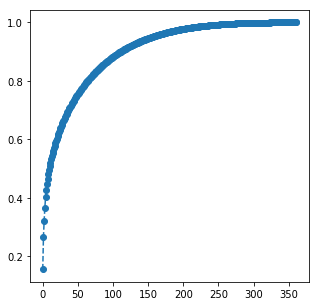

In [42]:
#using pca
pca = PCA() 
pca.fit(population)

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
cumulativeValue = pca.explained_variance_ratio_.cumsum()

#ploting the cumulative value as below
plt.figure(figsize= (5, 5))
plt.plot(ind, cumulativeValue, marker = 'o', linestyle="--");

In [45]:
#getting col with explain 70% +
df= pd.DataFrame(cumulativeValue,columns=["cum_variance"])
mask=df.cum_variance > 0.70
k=df[mask].index[0]

print(k)

37


In [48]:
pca = PCA(n_components=37)
newpop_data = pca.fit_transform(population)
print(newpop_data.shape)

(2000, 37)


In [49]:
pca = PCA(n_components=37) # init pca
newcust_data=pca.fit_transform(customers) 
# fiting the dataset into pca model


We have fit the number of customers and population using PCA best features. Now, lets obtain and then visualize the clusters

In [50]:
#using wecss
wcss = []
for i in range(1,20):
  kmeans = KMeans(n_clusters = i, init = 'k-means++',random_state=42)
  kmeans.fit(newpop_data)
  wcss.append(kmeans.inertia_)

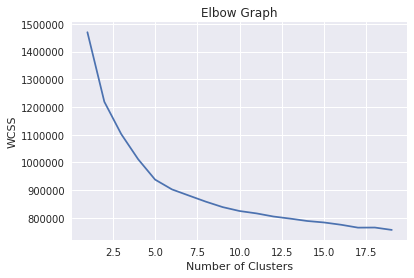

In [52]:
#plotting the elbow graph
sns.set()
plt.plot(range(1,20),wcss)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [51]:
#kmean clustring
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
#gettinglabel for each data point for each cluster
Y = kmeans.fit_predict(newpop_data)
print(Y)

Z= kmeans.fit_predict(newcust_data)
print(Z)

[0 3 0 ..., 0 0 9]
[0 1 0 ..., 6 0 9]


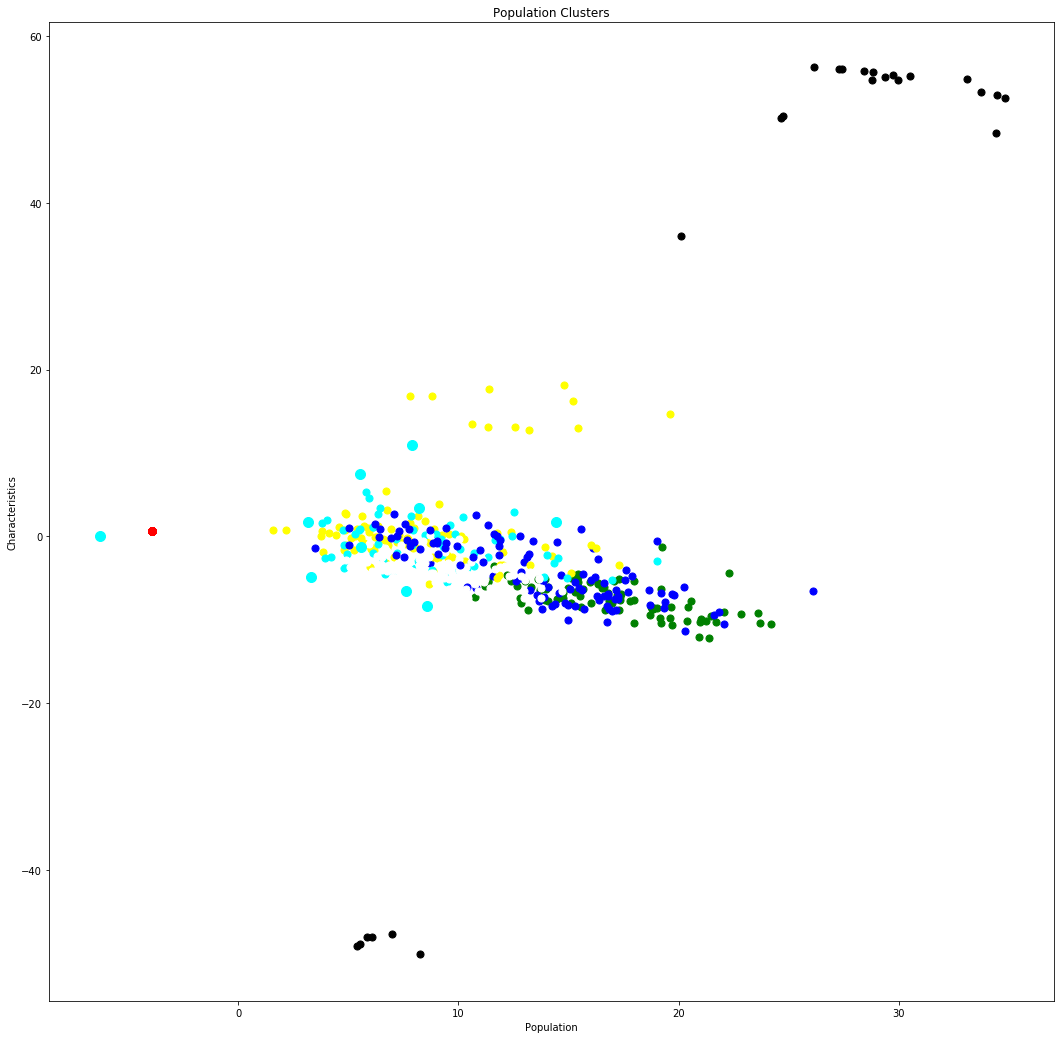

In [52]:
#showing the 10 clusters
plt.figure(figsize=(18,18))
plt.scatter(newpop_data[Y==0,0],newpop_data[Y==0,1],s=50,c= 'red',label = 'Cluster 1')
plt.scatter(newpop_data[Y==1,0],newpop_data[Y==1,1],s=50,c= 'green',label = 'Cluster 2')
plt.scatter(newpop_data[Y==2,0],newpop_data[Y==2,1],s=50,c= 'blue',label = 'Cluster 3')
plt.scatter(newpop_data[Y==3,0],newpop_data[Y==3,1],s=50,c= 'yellow',label = 'Cluster 4')
plt.scatter(newpop_data[Y==4,0],newpop_data[Y==4,1],s=50,c= 'black',label = 'Cluster 5')
plt.scatter(newpop_data[Y==5,0],newpop_data[Y==5,1],s=50,c= 'cyan',label = 'Cluster 6')
plt.scatter(newpop_data[Y==6,0],newpop_data[Y==6,1],s=50,c= 'white',label = 'Cluster 7')
plt.scatter(newpop_data[Y==7,0],newpop_data[Y==7,1],s=50,c= 'blue',label = 'Cluster 8')
plt.scatter(newpop_data[Y==8,0],newpop_data[Y==8,1],s=50,c= 'yellow',label = 'Cluster 9')
plt.scatter(newpop_data[Y==9,0],newpop_data[Y==9,1],s=50,c= 'black',label = 'Cluster 10')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s= 100, c = 'cyan', label = 'Centroids')

plt.title('Population Clusters')
plt.xlabel('Population')
plt.ylabel('Characteristics')

plt.show()

In [55]:
# the clusters

cluster_info = pd.DataFrame([])
cluster_info["Population"] = pd.Series(Y).value_counts().sort_index()
cluster_info["Customers"] = pd.Series(Z).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [56]:
cluster_info

,Cluster,Population,Customers
0,0,1505,933
1,1,84,69
2,2,66,195
3,3,87,148
4,4,18,1
5,5,60,91
6,6,119,177
7,7,44,176
8,8,11,23
9,9,6,187


In [57]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(0)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(0)

In [58]:
cluster_info

,Cluster,Population,Customers,Pop_proportion,Cust_proportion
0,0,1505,933,75.0,47.0
1,1,84,69,4.0,3.0
2,2,66,195,3.0,10.0
3,3,87,148,4.0,7.0
4,4,18,1,1.0,0.0
5,5,60,91,3.0,5.0
6,6,119,177,6.0,9.0
7,7,44,176,2.0,9.0
8,8,11,23,1.0,1.0
9,9,6,187,0.0,9.0


potential customers will be coming from clusters 0,6,3

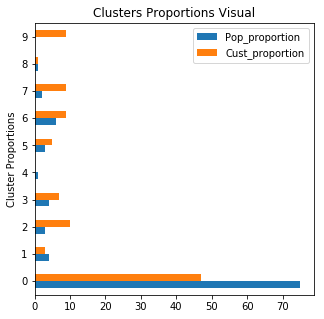

In [61]:
cluster_info.plot(x='Cluster', y = ['Pop_proportion', 'Cust_proportion'], kind='barh', figsize=(5,5))
plt.title('Clusters Proportions Visual')
plt.ylabel('Cluster Proportions')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [62]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [67]:
mailout_train.shape

(42962, 367)

In [63]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [64]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [65]:
newmail_data=clean_data(mailout_train,attributes)

after filling


In [66]:
newmail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(357)
memory usage: 117.0 MB


In [67]:
newmail_data.RESPONSE.value_counts()

-0.089843     42618
 11.130568      344
Name: RESPONSE, dtype: int64

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(newmail_data.RESPONSE)
print(le.classes_)
le.transform

[ -0.08984268  11.13056759]


<bound method LabelEncoder.transform of LabelEncoder()>

In [73]:
newmail_data.RESPONSE.value_counts()

-0.089843     42618
 11.130568      344
Name: RESPONSE, dtype: int64

after cleaning will start doing models

In [74]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
Y_encoded = lab_enc.fit_transform(newmail_data.RESPONSE)
print(utils.multiclass.type_of_target(newmail_data.RESPONSE))
print(utils.multiclass.type_of_target(newmail_data.RESPONSE.astype('int')))
print(utils.multiclass.type_of_target(Y_encoded))


continuous
binary
binary


In [75]:
X = newmail_data.drop(['RESPONSE'], axis=1)
Y = Y_encoded
print(X.shape,Y.shape)

(42962, 356) (42962,)


In [76]:
#splitting the data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = .1, stratify = Y, random_state = 2)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(38665, 356) (4297, 356) (38665,) (4297,)


In [77]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from timeit import timeit
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [78]:
%%time
#random forset good and general classifier will try it with 5 diffrent values
rf = RandomForestClassifier()
params_rf = {'n_estimators': [5,10,25,50,100, 200]}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train, Y_train)

CPU times: user 2min 30s, sys: 0 ns, total: 2min 30s
Wall time: 2min 31s


In [79]:
#best model
rf_best = rf_gs.best_estimator_

In [83]:
%%time
#logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

CPU times: user 21.4 s, sys: 12.2 ms, total: 21.4 s
Wall time: 21.6 s


In [85]:
#test the two models
print('rf: {}'.format(rf_best.score(X_test, Y_test)))
print('lr: {}'.format(log_reg.score(X_test, Y_test)))

rf: 0.9920875029090063
lr: 0.99185478240633


In [86]:
from sklearn.ensemble import VotingClassifier
#creating dictionary for models
estimators=[('rf', rf_best), ('log_reg', log_reg)]
ensemble = VotingClassifier(estimators, voting='hard')

In [87]:
%%time
ensemble.fit(X_train, Y_train)
print(ensemble.score(X_test, Y_test))

0.992087502909
CPU times: user 22.4 s, sys: 0 ns, total: 22.4 s
Wall time: 22.6 s


In [88]:
Y_pred=ensemble.predict(X_test)

In [89]:
 confusion_matrix(Y_test, Y_pred)

array([[4263,    0],
       [  34,    0]])

there might be an over fiting

In [90]:
roc=roc_auc_score(Y_test, log_reg.predict_proba(X_test)[:,1])
roc

0.75237681279408308

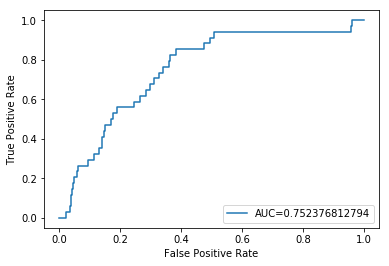

In [92]:
Y_pred_proba = log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)

#ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

our model with 0.75 wich is good 

## Conclusion

this project was really fun and got to use real world data and getting used to it 
and it made my data cleaning skills better
A few things standout:
1. the model done well.
2. there was a lot of data cleaning and handling .
3. ROC score of 0.75 is good.
4. a lot of data got deletet and more model could have been used like xgboost